In [263]:
#coding=utf-8
import os
import json
import csv
import argparse
import pandas as pd
import numpy as np
from math import ceil
from tqdm import tqdm
import pickle
import shutil

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
from torchvision import datasets, models
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

from transforms import transforms
from models.LoadModel import MainModelSmall
from utils.dataset_DCL import collate_fn4train, collate_fn4test, collate_fn4val, dataset
from config import LoadConfig, load_data_transformers
from utils.test_tool import set_text, save_multi_img, cls_base_acc

import pdb

os.environ['CUDA_DEVICE_ORDRE'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'



In [276]:
class Config:
    use_dcl = False
    numcls = 53
    backbone = 'resnet50'
    use_Asoftmax = False
    cls_2=False
    cls_2xmul=True

In [376]:
model = MainModelSmall(Config)
model_dict=model.state_dict()
pretrained_dict=torch.load('net_model/training_descibe_5x5_small_256_92410_CHAM/weights_358_38_0.9967_1.0000.pth')
pretrained_dict = {k[7:]: v for k, v in pretrained_dict.items() if k[7:] in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model.cuda()
model.eval()



resnet50


MainModelSmall(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [377]:
model.classifier=nn.Identity()


In [378]:
from PIL import Image
import os
import numpy as np
import torch
import glob
import matplotlib.pyplot as plt

In [379]:
def compute_metrics(gt_dict, retrieved_results, k=5):
    precision_values = []
    recall_values = []
    average_precisions = []
    topk_missing_accuracies = []  # Store Top-k missing accuracy
    redundancy_values = []  # Store redundancy values

    for category, gt_images in gt_dict.items():
        retrieved_images = retrieved_results.get(category, [])[:k]
        
        # True Positives
        tp = len(set(gt_images) & set(retrieved_images))
        
        # Precision and Recall
        precision = tp / len(retrieved_images) if retrieved_images else 0
        recall = tp / len(gt_images) if gt_images else 0
        
        precision_values.append(precision)
        recall_values.append(recall)
        
        # Calculate Average Precision (AP)
        if retrieved_images:
            relevant = 0
            cum_precision = 0
            for idx, image in enumerate(retrieved_images, start=1):
                if image in gt_images:
                    relevant += 1
                    cum_precision += relevant / idx
            ap = cum_precision / len(gt_images)
        else:
            ap = 0
        average_precisions.append(ap)
        
        # Calculate Top-k Missing Accuracy
        topk_retrieved_images = retrieved_images[:k]  # Get the top-k retrieved images
        if len(topk_retrieved_images) > 0:
            # Check if the true label is missing in the top-k retrieved images
            missing_in_topk = len([img for img in gt_images if img  not in topk_retrieved_images]) / len(gt_images)
        else:
            missing_in_topk = 1  # If no images are retrieved, we consider it a full miss
        
        topk_missing_accuracies.append(missing_in_topk)

        # Calculate Redundancy
        redundant_items = [img for img in retrieved_images if img not in gt_images]
        redundancy = len(redundant_items) / len(retrieved_images) if retrieved_images else 0
        redundancy_values.append(redundancy)
    # Calculate overall Top-k missing accuracy as the mean of individual accuracies
    overall_topk_missing = sum(topk_missing_accuracies) / len(topk_missing_accuracies) if topk_missing_accuracies else 0
    
    # Calculate overall redundancy as the mean of individual redundancies
    overall_redundancy = sum(redundancy_values) / len(redundancy_values) if redundancy_values else 0

    return precision_values, recall_values, average_precisions, overall_topk_missing, overall_redundancy


In [380]:
gt_file = open('../update_gt.txt','r').readlines()
gt_dict_simple ={}
for line in gt_file:
    split_line = line.rstrip('\n').split('\t')[-1].split('; ')
    if len(split_line)==1:
        continue
    gt_dict_simple[split_line[0]]=split_line[1:]

In [381]:
gt_file = open('../update_gt.txt','r').readlines()
gt_dict ={}
for line in gt_file:
    split_line = line.rstrip('\n').split('\t')[-1].split('; ')
    if len(split_line)==1:
        continue
    for idx, img in enumerate(split_line):
        gt_dict[img] = [x for x in split_line if x != img]


In [382]:
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.485, 0.456, 0.406) , (0.229, 0.224, 0.225))

])

In [383]:
list_img = []
gt_file = open('../update_gt.txt','r').readlines()
for line in gt_file:
    split_line = line.rstrip('\n').split('\t')[-1].split('; ')
    if len(split_line)==1:
        continue
    list_img.extend(split_line)
list_img = [os.path.join('../test-Stamp',i) for i in list_img]
print(len(list_img))
list_short_img = []
gt_file = open('../update_gt.txt','r').readlines()
for line in gt_file:
    split_line = line.rstrip('\n').split('\t')[-1].split('; ')
    if len(split_line)==1:
        continue
    list_short_img.append(split_line[0])
list_feats = []
list_names = []
feats =[]
with torch.no_grad():
    for i , file in enumerate(list_img):
        list_names.append(os.path.basename(file))
        img = Image.open(file).convert('RGB')
        img = transform(img)
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        #out = model.model(img)
        #out = model.reduce_chanel(out)
        #out = model.avgpool(out)
        #out = out.view(1,-1)
        out, _ = model(img)
        list_feats.append(out[0].cpu())


156


In [384]:
list_feats = torch.cat(list_feats,dim=0)

In [385]:
from sklearn.neighbors import NearestNeighbors

# Define the KNN model with cosine distance
#knn_model = NearestNeighbors(metric='cosine')
knn_model = NearestNeighbors(metric='cosine')

knn_model.fit(list_feats.cpu())

# Find the k-nearest neighbors for each point (including the point itself as the nearest)
k = 21 # Example: finding 5 nearest neighbors

# Query for the k-nearest neighbors
distances, indices = knn_model.kneighbors(list_feats.cpu(), n_neighbors=k)
knn_retrieved_results ={}
for i, img in enumerate(list_names):
    #if img in list_short_img: 
        similar_indices = indices[i,1:]  # Exclude the image itself
        similar_distances = distances[i,1:]  # Exclude the image itself
        #similar_indices = [t for idx, t in enumerate(similar_indices) if similar_distances[idx] < 0.31]
        if len(similar_indices) > 0:
            retrieved_images= [list_names[t] for t in similar_indices]
#             if average_precisions[i]<0.5:
#                 print('mAP',average_precisions[i])
#                 visual(img, gt_dict[img], retrieved_images)
            knn_retrieved_results[img] =retrieved_images


In [386]:
precision_values, recall_values, average_precisions, topk_correct, redundancy_score = compute_metrics(gt_dict, knn_retrieved_results,k)

# Step 4: Calculate Mean Average Precision (mAP)
mAP = sum(average_precisions) / len(average_precisions)

print(f"Average Precision values: {average_precisions}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")
print(f"Top-k Missing: {topk_correct:.4f}")
print(f"Redundancy: {redundancy_score:.4f}")


Average Precision values: [0.8993162393162393, 0.9157894736842105, 0.7617179311916152, 0.8490384615384615, 0.44883597883597875, 0.977124183006536, 0.9333333333333333, 0.795615101559374, 0.689819237636575, 0.013095238095238096, 0.9241269841269841, 0.775438596491228, 0.7590246354952238, 0.8829067990832697, 0.7574314574314573, 0.8145179820179821, 1.0, 0.8333333333333333, 0.3666666666666667, 0.5, 1.0, 0.125, 0.0625, 1.0, 0.9333333333333332, 0.9, 0.8708333333333332, 0.5189393939393939, 1.0, 0.5814814814814815, 1.0, 1.0, 0.28125, 0.0, 0.24583333333333332, 0.14583333333333331, 0.0, 0.3333333333333333, 0.3666666666666667, 1.0, 1.0, 0.6666666666666666, 0.3666666666666667, 1.0, 1.0, 1.0, 0.8975308641975308, 0.7326118326118327, 0.714491318412887, 0.7561728395061729, 0.7512345679012346, 0.7512345679012346, 0.75, 0.11425364758698092, 0.8401234567901233, 0.8438492063492062, 1.0, 1.0, 1.0, 1.0, 0.40240928280143967, 0.7634700176366843, 0.9575757575757575, 0.9575757575757575, 0.9575757575757575, 0.6731

In [15]:
def drawCMC(cmc_dict):
    # Rank values (x-axis)
    x = range(1, len(next(iter(cmc_dict.values()))['missing error']) + 1)

    # Plotting CMC curves for each method
    plt.figure(figsize=(12, 8))

    for method, values in cmc_dict.items():
        plt.plot(x, values['missing error'], label=f'{method} - Missing Error', marker='o')
        plt.plot(x, values['mAP'], label=f'{method} - mAP', marker='x')
        plt.plot(x, values['redundancy error'], label=f'{method} - Redundancy', marker='s')
    key, value = cmc_dict.popitem()
    # Adding titles and labels
    plt.title(key)
    plt.xlabel('Rank (k)')
    plt.ylabel('%')
    plt.xticks(x)  # Force x-axis to show integers
    plt.legend()

    # Display grid and plot
    plt.grid(True)
    plt.show()

In [19]:
cmc_dict = {}
name_exp = 'FinetuningDCLwithCutOff'
cmc_dict[name_exp] = {}
cmc_dict[name_exp]['missing error']=[]
cmc_dict[name_exp]['mAP']=[]
cmc_dict[name_exp]['redundancy error']=[]

def return_dict_for_CMC(list_feats, list_names,gt_dict):
    knn_model = NearestNeighbors(metric='cosine')
    knn_model.fit(list_feats.cpu())

    # Query for the k-nearest neighbors

    for k in np.arange(2,25):
        distances, indices = knn_model.kneighbors(list_feats.cpu(), n_neighbors=k)
        knn_retrieved_results ={}
        for i, img in enumerate(list_names):
            #if img in list_short_img: 
                similar_indices = indices[i,1:]  # Exclude the image itself
                similar_distances = distances[i,1:]  # Exclude the image itself
                #similar_indices = [t for idx, t in enumerate(similar_indices) if similar_distances[idx] < 0.025]
                if len(similar_indices) > 0:
                    retrieved_images= [list_names[t] for t in similar_indices]
                    knn_retrieved_results[img] =retrieved_images
        _, _, average_precisions, overall_topk_missing, overall_redundancy = compute_metrics(gt_dict, knn_retrieved_results,k)
        cmc_dict[name_exp]['missing error'].append(overall_topk_missing*100)
        cmc_dict[name_exp]['mAP'].append(sum(average_precisions) / len(average_precisions)*100)
        cmc_dict[name_exp]['redundancy error'].append(overall_redundancy*100)


In [20]:
return_dict_for_CMC(list_feats, list_names, gt_dict)

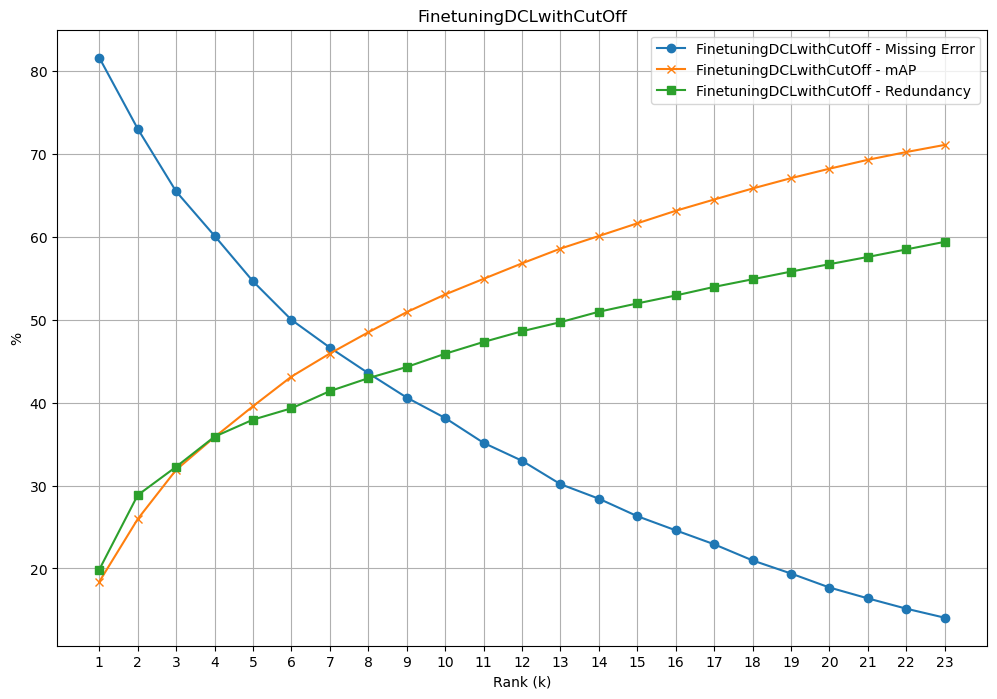

In [21]:
drawCMC(cmc_dict)

# Simple Classification

In [22]:
file = open('../full_aug_update_training.txt', 'r').readlines()

# Process ground truth and image paths
dict_mapping = {}
for line in file:
    split_line = line.rstrip('\n').split('\t')
    dict_mapping[int(split_line[0])] = split_line[1]

In [23]:
dict_mapping

{0: '-1',
 1: '-2',
 2: '-3',
 3: '-4',
 4: '30',
 5: '0',
 6: '11',
 7: '-5',
 9: '-6',
 10: '-7',
 11: '-8',
 12: '-9',
 13: '-10',
 14: '4',
 15: '-11',
 16: '-12',
 17: '6',
 18: '-13',
 19: '-14',
 20: '-15',
 21: '20',
 22: '-16',
 23: '-17',
 24: '-18',
 25: '-19',
 26: '-20',
 27: '-21',
 28: '-22',
 29: '-23',
 30: '18',
 31: '-24',
 32: '-25',
 33: '-26',
 34: '12',
 35: '-27',
 36: '38',
 37: '-28',
 38: '9',
 39: '-29',
 40: '13',
 41: '16',
 42: '22',
 43: '24',
 44: '28',
 45: '33',
 46: '32',
 47: '35',
 48: '1',
 49: '14',
 50: '23',
 51: '32',
 52: '37'}

In [27]:
model

MainModelSmall(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [31]:
import os
import torch
from PIL import Image

list_img = []
list_gt = []

# Reading the ground truth file
gt_file = open('../update_gt.txt', 'r').readlines()

# Process ground truth and image paths
for line in gt_file:
    split_line = line.rstrip('\n').split('\t')[-1].split('; ')
    gt = line.rstrip('\n').split('\t')[0]
    if len(split_line) == 1:
        continue
    list_img.extend(split_line)
    list_gt.extend([gt] * len(split_line))
# Update list_img paths
list_img = [os.path.join('../test-Stamp', i) for i in list_img]

# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = len(list_img)

list_names = []

# Disable gradient calculation
with torch.no_grad():
    for i, file in enumerate(list_img):
        # Append the image file name
        list_names.append(os.path.basename(file))
        
        # Load and transform the image
        img = Image.open(file).convert('RGB')
        img = transform(img)  # Assuming `transform` is defined elsewhere
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        
        # Get the model's prediction
        out = model(img)
        # Convert model output to predicted label (assuming classification)
        _, predicted_label = torch.max(out[0], 1)  # Get the label with the highest score
        predicted_label = predicted_label.item()  # Convert to a Python integer
        predicted_label =dict_mapping[predicted_label]

        # Compare the predicted label with the ground truth
        if str(predicted_label) == list_gt[i]:  # Assuming `list_gt[i]` is a string
            correct_predictions += 1

# Compute accuracy
accuracy = correct_predictions / total_predictions * 100

# Print the accuracy
print(f'Accuracy: {accuracy:.2f}%')


torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])
torch.Size([1, 53])


In [310]:
class SE(nn.Module):
    def __init__(self, normalization_type="l2"):
        """
        SE module for similarity extraction.
        
        Args:
            normalization_type: Type of normalization to apply ('l2' or 'min-max').
        """
        super(SE, self).__init__()
        self.normalization_type = normalization_type

    def normalize(self, features):
        """
        Normalize each feature vector independently.
        
        Args:
            features (torch.Tensor): Input tensor of shape (B, n, c), where B is batch size,
                                     n is the number of local features (flattened patches), and c is the feature dimension.
        
        Returns:
            torch.Tensor: Normalized features of shape (B, n, c).
        """
        if self.normalization_type == "l2":
            # L2 normalization: Normalize each feature vector to unit length
            features = F.normalize(features, p=2, dim=-1)  # Normalize along the last dimension (c)
        
        elif self.normalization_type == "min-max":
            # Min-Max normalization: Scale each feature vector to the range [0, 1]
            min_val = features.min(dim=-1, keepdim=True)[0]  # Min along feature dimension (c)
            max_val = features.max(dim=-1, keepdim=True)[0]  # Max along feature dimension (c)
            features = (features - min_val) / (max_val - min_val + 1e-5)  # Normalize between 0 and 1
        
        return features

    def forward(self, x):
        """
        Forward pass of the SE module.
        
        Args:
            x (torch.Tensor): Input feature maps of shape (B, c, h, w).
        
        Returns:
            torch.Tensor: Similarity map of shape (B, n, n), where n = h * w.
        """
        
        # Normalize each local feature vector
        x = self.normalize(x)  # Shape: (B, n, C)

        # Compute similarity map: dot-product similarity XX^T
        similarity_matrix = torch.bmm(x, x.transpose(1, 2))  # Shape: (B, n, n)
        
        # Apply Gaussian similarity (optional, or any other transformation on the similarity matrix)
        # gaussian_similarity = torch.exp(-similarity_matrix)  # Optional: Gaussian similarity
        
        return similarity_matrix
class RE(nn.Module):
    def __init__(self, feature_dim, num_bases):
        super(RE, self).__init__()
        self.irim = IRIM(feature_dim, num_bases)
        self.se = SE()

    def forward(self, features):
        implicit_features = self.irim(features)
        print(implicit_features.shape)
        similarity_matrix = self.se(implicit_features)
        return similarity_matrix

In [579]:
class IRIM(nn.Module):
    def __init__(self, num_bases):
        super(IRIM, self).__init__()
        self.num_bases = num_bases
        #self.bases = nn.Parameter(torch.randn(num_bases, feature_dim))

    def forward(self, features):
        B, seq_len, feature_dim = features.shape
        mu = torch.randn(self.num_bases, feature_dim).cuda()
        features_reshaped = features.view(-1, feature_dim)  # (B * seq_len, feature_dim)

        for _ in range(3):

            # E-step: calculate latent variables (Z)
            # Compute scores for all bases
            scores = torch.matmul(features_reshaped, mu.T)  # (B * seq_len, num_bases)
            Z = torch.softmax(scores, dim=-1)  # (B * seq_len, num_bases)

            # Reshape `Z` back to (B, seq_len, num_bases)
            Z = Z.view(B, seq_len, self.num_bases)  # (B, seq_len, num_bases)

            # M-step: update the bases
            # Reshape `Z` and `features` for the M-step computation
            Z_reshaped = Z.view(B * seq_len, self.num_bases)  # (B * seq_len, num_bases)
            weighted_sum = torch.matmul(Z_reshaped.T, features_reshaped)  # (num_bases, feature_dim)
            sum_weights = Z_reshaped.sum(dim=0, keepdim=True)  # (1, num_bases)

            # Update bases
            # Avoid division by zero by adding a small constant
            mu = weighted_sum / (sum_weights + 1e-8).T  # (num_bases, feature_dim)

            # Reconstruct features using the learned implicit relations
            # Flatten `self.bases` for matrix multiplication
            features_reshaped = torch.matmul(Z.view(-1, self.num_bases), mu)  # (B * seq_len, feature_dim)

            # Reshape the output back to (B, seq_len, feature_dim)
        features_reshaped = features_reshaped.view(B, seq_len, feature_dim)  # (B, seq_len, feature_dim)
        
        return features_reshaped
class SE(nn.Module):
    def __init__(self, normalization_type="l2"):
        """
        SE module for similarity extraction.
        
        Args:
            normalization_type: Type of normalization to apply ('l2' or 'min-max').
        """
        super(SE, self).__init__()
        self.normalization_type = normalization_type

    def normalize(self, features):
        """
        Normalize each feature vector independently.
        
        Args:
            features (torch.Tensor): Input tensor of shape (B, n, c), where B is batch size,
                                     n is the number of local features (flattened patches), and c is the feature dimension.
        
        Returns:
            torch.Tensor: Normalized features of shape (B, n, c).
        """
        if self.normalization_type == "l2":
            # L2 normalization: Normalize each feature vector to unit length
            features = F.normalize(features, p=2, dim=-1)  # Normalize along the last dimension (c)
        
        elif self.normalization_type == "min-max":
            # Min-Max normalization: Scale each feature vector to the range [0, 1]
            min_val = features.min(dim=-1, keepdim=True)[0]  # Min along feature dimension (c)
            max_val = features.max(dim=-1, keepdim=True)[0]  # Max along feature dimension (c)
            features = (features - min_val) / (max_val - min_val + 1e-5)  # Normalize between 0 and 1
        
        return features

    def forward(self, x):
        """
        Forward pass of the SE module.
        
        Args:
            x (torch.Tensor): Input feature maps of shape (B, c, h, w).
        
        Returns:
            torch.Tensor: Similarity map of shape (B, n, n), where n = h * w.
        """
        
        # Normalize each local feature vector
        #x = self.normalize(x)  # Shape: (B, n, C)

        # Compute similarity map: dot-product similarity XX^T
        similarity_matrix = torch.bmm(x, x.transpose(1, 2))  # Shape: (B, n, n)
        
        # Apply Gaussian similarity (optional, or any other transformation on the similarity matrix)
        # gaussian_similarity = torch.exp(-similarity_matrix)  # Optional: Gaussian similarity
        
        return similarity_matrix

In [580]:
# irim = IRIM(256,256)
# se = SE()
# se.cuda()
# irim.cuda()

In [581]:
# class IRIM:
#     def __init__(self, n_bases, c):
#         self.mu = nn.Parameter(torch.randn(n_bases, c))
#         self.mu = self.mu.cuda()
#     def e_step(self, X):
#         Z = torch.einsum('nic,kc->nik', X, self.mu)
#         return Z / Z.sum(dim=2, keepdim=True)

#     def m_step(self, X, Z):
#         numerator = torch.einsum('nic,nik->kc', X, Z)
#         denominator = Z.sum(dim=(0, 1)).unsqueeze(1)
#         self.mu = numerator / denominator

#     def fit(self, X, num_iterations=3):
#         for _ in range(num_iterations):
#             Z = self.e_step(X)
#             self.m_step(X, Z)
#         return self

#     def extract_features(self, X):
#         Z = self.e_step(X)
#         return F.softmax(Z, dim=2)

#     def reconstruct(self, X):
#         Z = self.e_step(X)
#         #print(Z.shape)
#         #print(X.shape)
#         return torch.matmul(Z,self.mu)
#         #return torch.einsum('nik,kc->nic', Z, X)

In [582]:
# class IRIM_GPT(nn.Module):
#     def __init__(self, feature_dim, num_bases):
#         super(IRIM_GPT, self).__init__()
#         self.num_bases = num_bases
#         self.bases = nn.Parameter(torch.randn(num_bases, feature_dim)).cuda()

#     def forward(self, features):
#         for _ in range(3):
#             # E-step: calculate latent variables (Z)
#             Z = torch.softmax(torch.matmul(features, self.bases.T), dim=-1)

#             # M-step: update the bases
#             self.bases = torch.matmul(Z.T, features) / Z.sum(dim=0, keepdim=True)

#         # Output: reconstructed features using implicit relations
#         reconstructed_features = torch.matmul(Z, self.bases)
#         return reconstructed_features

In [583]:
# list_img = []
# gt_file = open('../full_aug_update_training.txt','r').readlines()
# for line in gt_file:
#     split_line = line.rstrip('\n').split('\t')[-1].split('; ')
#     if len(split_line)==1:
#         continue
#     list_img.extend(split_line)
# list_img = [os.path.join('../New-pos-data/',i) for i in list_img]
# print(len(list_img))

# list_feats = []
# list_names = []
# feats =[]
# with torch.no_grad():
#     for i , file in enumerate(list_img):
#         list_names.append(os.path.basename(file))
#         img = Image.open(file).convert('RGB')
#         img = transform(img)
#         img = torch.unsqueeze(img, 0)
#         img = img.cuda()
#         x = model.model[:8](img)  # Up to the 7th Sequential layer
#         x= model.reduce_chanel(x)
#         x=  x.view(1,-1,256)
#         list_feats.append(x)


In [514]:
#list_feats = torch.cat(list_feats,dim=0)

In [518]:
#irim_model = IRIM(25, 256).fit(list_feats)


IRIM()

In [584]:
irim_gpt= IRIM(25)
irim_gpt.cuda()

IRIM()

In [599]:
list_img = []
gt_file = open('../update_gt.txt','r').readlines()
for line in gt_file:
    split_line = line.rstrip('\n').split('\t')[-1].split('; ')
    if len(split_line)==1:
        continue
    list_img.extend(split_line)
list_img = [os.path.join('../test-Stamp',i) for i in list_img]
print(len(list_img))

list_feats_test = []
list_names_test = []
with torch.no_grad():
    for i , file in enumerate(list_img):
        list_names_test.append(os.path.basename(file))
        img = Image.open(file).convert('RGB')
        img = transform(img)
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        x = model.model[:8](img)  # Up to the 7th Sequential layer
        x = model.reduce_chanel(x)
        #out, _ = model(img)
        #print(out[0].shape)
        #assert 1==2
        x =  x.view(1,-1,256)

        # Extract features (implicit relation information) for the input
        #Z_final = irim.extract_features(x)
        #print(Z_final.shape)
        #assert 1==2
        # Reconstruct the input

        X = irim_gpt(x)
        se_X = se(X)
        #se_feats = se_X.view(1,-1)
        se_x = se(x)
        se_feats = se_X #+se_x
        se_feats = se_feats.view(1,-1)
        list_feats_test.append(se_feats)
list_feats_test = torch.cat(list_feats_test, dim=0)

156


In [600]:
se_feats.shape

torch.Size([1, 625])

In [601]:
# list_img = []
# gt_file = open('../update_gt.txt','r').readlines()
# for line in gt_file:
#     split_line = line.rstrip('\n').split('\t')[-1].split('; ')
#     if len(split_line)==1:
#         continue
#     list_img.extend(split_line)
# list_img = [os.path.join('../test-Stamp',i) for i in list_img]
# print(len(list_img))
# list_short_img = []
# gt_file = open('../update_gt.txt','r').readlines()
# for line in gt_file:
#     split_line = line.rstrip('\n').split('\t')[-1].split('; ')
#     if len(split_line)==1:
#         continue
#     list_short_img.append(split_line[0])
# list_feats = []
# list_names = []
# feats =[]
# with torch.no_grad():
#     for i , file in enumerate(list_img):
#         list_names.append(os.path.basename(file))
#         img = Image.open(file).convert('RGB')
#         img = transform(img)
#         img = torch.unsqueeze(img, 0)
#         img = img.cuda()
#         x = model.model[:8](img)  # Up to the 7th Sequential layer
#         #x = model.model[7][0](x)  # Pass through the first bottleneck in the last layer
#         #x = model.model[7][1](x)  # Pass through the second bottleneck
#         #x = model.model[7][2](x)  # Pass through the third bottleneck (last bottleneck)
#         #x = model.model[7][2].relu(x)  # Get output after last ReLU
#         x = model.reduce_chanel(x)
#         x =  x.view(1,-1,128)
#         x_irim = irim(x)
#         #se_feats = se_irim +se_x
#         se_feats = x_irim.view(1,-1)
#         list_feats.append(se_feats)
# list_feats = torch.cat(list_feats,dim=0)

In [602]:
from sklearn.neighbors import NearestNeighbors

# Define the KNN model with cosine distance
#knn_model = NearestNeighbors(metric='cosine')
knn_model = NearestNeighbors(metric='cosine')

knn_model.fit(list_feats_test.cpu())

# Find the k-nearest neighbors for each point (including the point itself as the nearest)
k = 21 # Example: finding 5 nearest neighbors

# Query for the k-nearest neighbors
distances, indices = knn_model.kneighbors(list_feats_test.cpu(), n_neighbors=k)
knn_retrieved_results ={}
for i, img in enumerate(list_names_test):
    #if img in list_short_img: 
        similar_indices = indices[i,1:]  # Exclude the image itself
        similar_distances = distances[i,1:]  # Exclude the image itself
        #similar_indices = [t for idx, t in enumerate(similar_indices) if similar_distances[idx] < 0.31]
        if len(similar_indices) > 0:
            retrieved_images= [list_names_test[t] for t in similar_indices]
#             if average_precisions[i]<0.5:
#                 print('mAP',average_precisions[i])
#                 visual(img, gt_dict[img], retrieved_images)
            knn_retrieved_results[img] =retrieved_images


In [603]:
precision_values, recall_values, average_precisions, topk_correct, redundancy_score = compute_metrics(gt_dict, knn_retrieved_results,k)

# Step 4: Calculate Mean Average Precision (mAP)
mAP = sum(average_precisions) / len(average_precisions)

print(f"Average Precision values: {average_precisions}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")
print(f"Top-k Missing: {topk_correct:.4f}")
print(f"Redundancy: {redundancy_score:.4f}")


Average Precision values: [0.7260654922419628, 0.5227967354283144, 0.5908089668615985, 0.6358054736228111, 0.44265182186234814, 0.5578352148940383, 0.7816524216524215, 0.7442890442890443, 0.44740740740740736, 0.011111111111111112, 0.687418159182865, 0.4674473640108315, 0.23426686144952397, 0.6375783475783476, 0.5197557997557998, 0.5515897555603437, 0.5, 0.3333333333333333, 0.5555555555555556, 0.1111111111111111, 0.25, 0.0, 0.06666666666666667, 0.9102564102564102, 0.7875, 0.5694444444444444, 0.3735145573380867, 0.46527777777777773, 0.31666666666666665, 0.5722222222222222, 0.25, 1.0, 0.020833333333333332, 0.016666666666666666, 0.05119047619047619, 0.08333333333333333, 0.0, 0.03333333333333333, 0.25, 0.16666666666666666, 0.25, 0.6666666666666666, 0.25, 1.0, 0.8333333333333333, 1.0, 0.5009700176366843, 0.6801375095492743, 0.5240740740740741, 0.32592592592592595, 0.621324354657688, 0.6293918557076451, 0.5379474011826955, 0.4276003398810416, 0.8717320261437909, 0.7185185185185186, 1.0, 1.0, 